In [1]:
# load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats.stats import pearsonr
from sklearn import linear_model
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error as mse
from sklearn import metrics
from sklearn import model_selection
from tqdm import tqdm

## Mission
- To find what factors most influence achievement test scores and acceptances to Specialised High Schools (SPS)
- For simplicity, achievement test scores will be measured using the `student_achievement` column and SPS acceptances will be measured using `acceptances`

## Data Processing

In [2]:
msData = pd.read_csv('data/middleSchoolData.csv')
msData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594 entries, 0 to 593
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   dbn                           594 non-null    object 
 1   school_name                   594 non-null    object 
 2   applications                  594 non-null    int64  
 3   acceptances                   594 non-null    int64  
 4   per_pupil_spending            473 non-null    float64
 5   avg_class_size                473 non-null    float64
 6   asian_percent                 592 non-null    float64
 7   black_percent                 592 non-null    float64
 8   hispanic_percent              592 non-null    float64
 9   multiple_percent              592 non-null    float64
 10  white_percent                 592 non-null    float64
 11  rigorous_instruction          551 non-null    float64
 12  collaborative_teachers        551 non-null    float64
 13  suppo

In [3]:
# Removing null values
msData['charter'] = msData['school_name'].str.contains(pat='charter', case=False) # check
reducedData = msData.dropna()

In [4]:
print("original data: False=public, True=charter", '\n', msData['charter'].value_counts())
print("reduced data: False=public, True=charter", '\n', reducedData['charter'].value_counts())

original data: False=public, True=charter 
 False    486
True     108
Name: charter, dtype: int64
reduced data: False=public, True=charter 
 False    449
Name: charter, dtype: int64


As shown above, by dropping the null values, all of the charter schools (108) were dropped along with 37 (486-449) public schools.
This analysis will only pertain to NYC public middle school

In [5]:
# Dropping dbn (column 1), school name (column 2), and charter (column 24) because they will not be used in analysis
reducedData = reducedData.drop(labels=['dbn','school_name','charter'], axis=1)

In [37]:
# select predictors/outcomes and standardize them
# outcome1: acceptances
# outcome2: achievement test scores
# predictor 1: all else, except for column 20 & 21 (reading and math scores) and column 1 (acceptances)
# predictor 2: all else, except for column 19,20,21 (student achievement, reading and math scores)

Y1 = StandardScaler().fit_transform( np.array(reducedData['acceptances']).reshape(-1,1) ) # acceptances
Y2 = StandardScaler().fit_transform( np.array(reducedData['student_achievement']).reshape(-1,1) ) # achievement test scores

# features:
predictors = pd.concat([reducedData.iloc[:,0],reducedData.iloc[:,2:20]],axis=1)
pred_df = pd.DataFrame(data=predictors.columns,columns=['predictors'])
X = StandardScaler().fit_transform(predictors) # predictor for acceptances

predictors = pd.concat([reducedData.iloc[:,0:2],reducedData.iloc[:,2:19]],axis=1)
pred_df2 = pd.DataFrame(data=predictors.columns,columns=['predictors'])
X2 = StandardScaler().fit_transform(predictors) # predictor for achievement test scores

## Probing

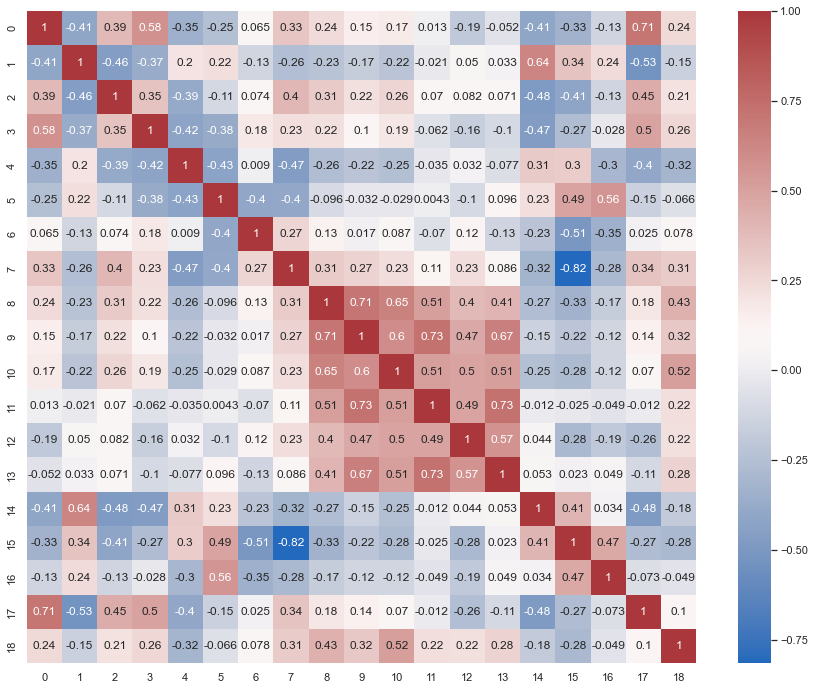

In [38]:
# correlation heat map
corr_matrix = np.corrcoef(X,rowvar=False)
sns.set(rc={'figure.figsize':(15,12)})
sns.heatmap(data=corr_matrix, annot=True,cmap="vlag") # "icefire"
plt.show()

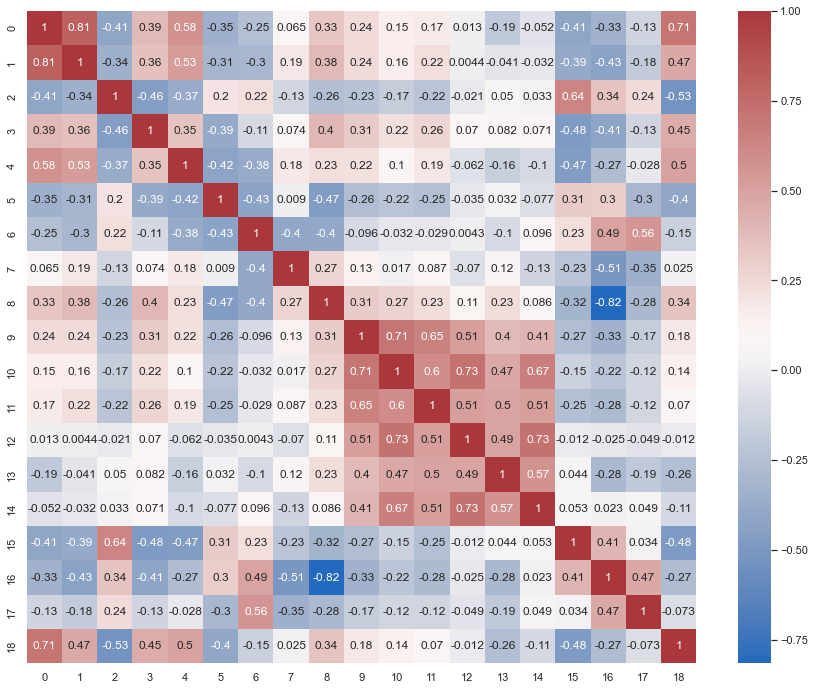

In [39]:
# correlation heat map
corr_matrix = np.corrcoef(X2,rowvar=False)
sns.set(rc={'figure.figsize':(15,12)})
sns.heatmap(data=corr_matrix, annot=True,cmap="vlag") # "icefire"
plt.show()

### Observations:
- Column 9-14 are highly correlated. These columns correspond to columns L-Q, which describe "school climate"
- In addition, there are many other groups of columns that are moderately correlated
- May need to perform some type of variable selection

### Initial Multiple Linear Regression
- Before moving into further analysis, I want to run a simple multiple linear regression with all predictors
- This will act as a base model to compare performance will other models

### SPS acceptances:

In [40]:
# base_model = bm
bm1 = LinearRegression().fit(X, Y1)
b0, b1 = bm1.intercept_, bm1.coef_

# computing metrics RMSE and R^2
rSqr = bm1.score(X, Y1)
p = 18
n = X.shape[0]
adj_rSqr = 1-(1-rSqr)*(n-1)/(n-18-1)
rmse = mse(y_true=Y1, y_pred=bm1.predict(X), squared=False)
bm1_metrics = [adj_rSqr, rmse]
print("Adjusted R^2", adj_rSqr)
print("RMSE:", rmse)
# printing coefficients of predictors
b1_df = pd.DataFrame(data=b1.T, columns=['base_Y1'])
bm1_results = pd.concat([pred_df, b1_df],axis=1)
bm1_results

Adjusted R^2 0.7043221019460275
RMSE: 0.5327269305255375


,predictors,base_Y1
0,applications,0.867077
1,per_pupil_spending,-0.008407
2,avg_class_size,0.011645
3,asian_percent,3.852973
4,black_percent,6.153784
5,hispanic_percent,5.997661
6,multiple_percent,0.607072
7,white_percent,4.276178
8,rigorous_instruction,-0.043776
9,collaborative_teachers,0.039989


### Achievement Test Scores

In [41]:
bm2 = LinearRegression().fit(X2, Y2)
b0, b1 = bm2.intercept_, bm2.coef_
rSqr = bm2.score(X2, Y2)
adj_rSqr = 1-(1-rSqr)*(n-1)/(n-18-1)
rmse = mse(y_true=Y2, y_pred=bm2.predict(X2), squared=False)
bm2_metrics = [adj_rSqr, rmse]
print("Adjusted R^2", adj_rSqr)
print("RMSE:", rmse)
b2_df = pd.DataFrame(data=b1.T, columns=['base_Y2'])
bm2_results = pd.concat([pred_df2, b2_df],axis=1)
bm2_results

Adjusted R^2 0.3411755321007285
RMSE: 0.7952067919459


,predictors,base_Y2
0,applications,0.089931
1,acceptances,0.042256
2,per_pupil_spending,-0.031753
3,avg_class_size,-0.037443
4,asian_percent,1.251001
5,black_percent,1.768683
6,hispanic_percent,1.800015
7,multiple_percent,0.157107
8,white_percent,1.459492
9,rigorous_instruction,0.189624


### Observations:
- When using all the predictors, the model better predicts SHS acceptances (Y1)($R^2=0.7$) compared to achievement test scores (Y2) ($R^2=0.34$)
- In both models, percentage of racial demographics (variable 4-8) have the highest coefficients
- This indicates that race is the strongest predictor
- However, there is an issue of multicollinearity, so these results are likely inaccurate

### Plan:
- Want to reduce these features because they are highly correlated as seen in the correlation matrix above
- Deploy several methods and compare performances
    - PCA and multiple regression (PCR)
    - Lasso/Ridge Regression
    - Random Forest

## PCA and Multiple Regression (PCR)

### SPS acceptances:

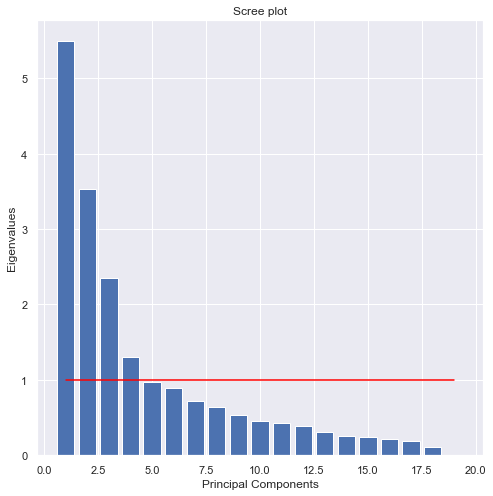

In [42]:
# running PCA
pca = PCA().fit(X)
eigVals = pca.explained_variance_
loadings = pca.components_
X_pca = pca.fit_transform(X)
covarExplained = eigVals/sum(eigVals)*100
# Scree plot:
numPredictors = 19
plt.figure(figsize=(8,8))
plt.bar(np.linspace(1,numPredictors,numPredictors),eigVals)
plt.plot([1,numPredictors],[1,1],color='red') # Kaiser criterion line
#plt.xticks(1,18)
plt.title('Scree plot')
plt.xlabel('Principal Components')
plt.ylabel('Eigenvalues')
plt.show()

# Based on Kaiser criterion: looking at Eigensum of 1 or greater
# PCA 1-4

In [43]:
np.sum(covarExplained[0:4])

66.60035446496185

In [44]:
np.sum(covarExplained[0:9])

86.34775112710584

Based on both the Kaiser and Elbow criterion, we should keep PC 1-4
- Additionally, it takes more than 10 PC to account for 90% of the variance. However, there is nearly half of the original predictors, and thus decreases the utility of PCA as a dimenesion reduction technique

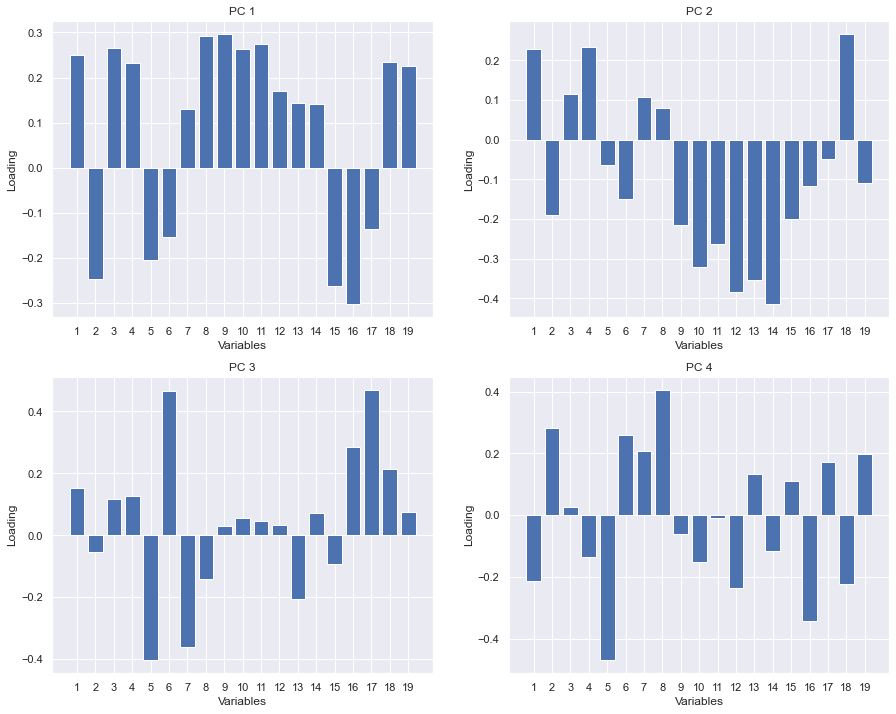

In [45]:
# interpreting loading values
# look at meaning
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
nums = np.linspace(1,19,19)
setting = {0:ax1,1:ax2,2:ax3,3:ax4}
for i,ax in setting.items():
    #ax.bar(np.linspace(1,18,18),loadings[i,:])
    ax.bar(np.linspace(1,19,19),loadings[i,:])
    ax.set_xlabel('Variables')
    ax.set_ylabel('Loading')
    ax.set_title("PC " + str(i+1))
    ax.set_xticks(nums)

- PC 1:
    - points positively towards variables 1,3,4,8-11,18 (`applications`,`school_size`,`asian_percent`,`white_percent`,`rigorous_instructions`,`colloborative_teachers`,`school_size`)
    - points negatively towards variables 2,5,15,16,17 (`per_pupil_spending`,`black_percent`,`disability_percent`,`poverty_percent`,`ESL_percent`)
    -  PC 1 represents school competence (how well run it is)
- PC 2:
    -points negative towards variables 9-14(`rigourous_instruction`,`colloborative_teachers`,`supportive_environment`,`effective_school_leadership`,`strong_family_community_ties`,`trust`)
    - PC 2 likely represents poor School Climate (hostile, unsupportive community)
- PC 3:
    - points positively towards variable 1,3,4,6,16,17,18 (`applications`, `avg_class_size`, `asian_percent`, `multiple_percent`,`poverty_percent`,`ESL_percent`,`school_size`)
    - points negatively towards variables 5,7 (`black_percent`,`multiple_percent`)
    - PC 3 represents larger school size
- PC 4:
    - points positively towards variable 2,6,8 (`per_pupil_spending`,`hispanic_percent`,`white_percent`)
    - points negatively towards variables 1,5,16,18(`applications`,`black_percent`,`poverty_percent`,`school_size`)
    - PC 3 represents small niche community (mostly white/hispanic)

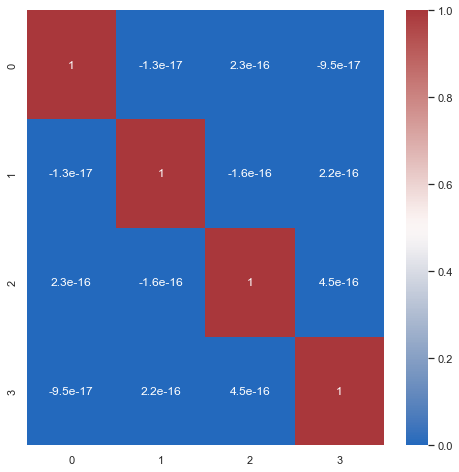

In [46]:
# checking correlation matrix of the 1st 4 PC
X_reduced = X_pca[:,0:4]
corr_matrix = np.corrcoef(X_reduced, rowvar=False)
plt.figure(figsize=(8,8))
sns.set(rc={'figure.figsize':(15,12)})
sns.heatmap(data=corr_matrix, annot=True,cmap="vlag") # "icefire"
plt.show()

As shown above, the correlation is much lower compared to that of the original predictors

In [47]:
# Run multiple regression with 1st four PC on both outcomes
model = LinearRegression().fit(X_reduced, Y1)
b0, b1 = model.intercept_, (model.coef_).T
rSqr = model.score(X_reduced, Y1)
p = 4
n = X.shape[0]
adj_rSqr = 1-(1-rSqr)*(n-1)/(n-p-1)
rmse = mse(y_true=Y1, y_pred=model.predict(X_reduced), squared=False)
pcr1_metrics = [adj_rSqr, rmse]
pca_dict = {"PC1: school competence":b1[0],
            "PC2: poor school climate":b1[1],
            "PC3: large school size":b1[2],
            "PC3: nice school community":b1[3]}
print("PCR on SHS acceptances")
print("Adjusted R^2", adj_rSqr)
print("RMSE:", rmse)
pcr1_results = pd.DataFrame.from_dict(data=pca_dict, orient='index',columns=['Coefficients'])
pcr1_results

PCR on SHS acceptances
Adjusted R^2 0.44467237354953815
RMSE: 0.7418688186407619


,Coefficients
PC1: school competence,0.244735
PC2: poor school climate,0.178071
PC3: large school size,0.043157
PC3: nice school community,-0.063294


### Achievement Test Scores:

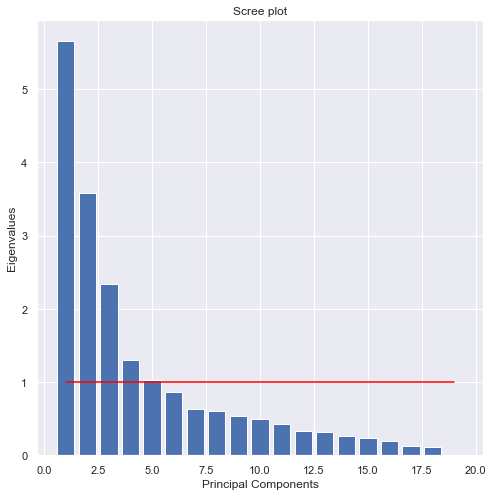

In [48]:
# running PCA
pca = PCA().fit(X2)
eigVals = pca.explained_variance_
loadings2 = pca.components_
X_pca2 = pca.fit_transform(X2)
covarExplained = eigVals/sum(eigVals)*100
# Scree plot:
numPredictors = 19
plt.figure(figsize=(8,8))
plt.bar(np.linspace(1,numPredictors,numPredictors),eigVals)
plt.plot([1,numPredictors],[1,1],color='red') # Kaiser criterion line
#plt.xticks(1,18)
plt.title('Scree plot')
plt.xlabel('Principal Components')
plt.ylabel('Eigenvalues')
plt.show()

Based on the Kaiser criterion, we keep PC 1-4

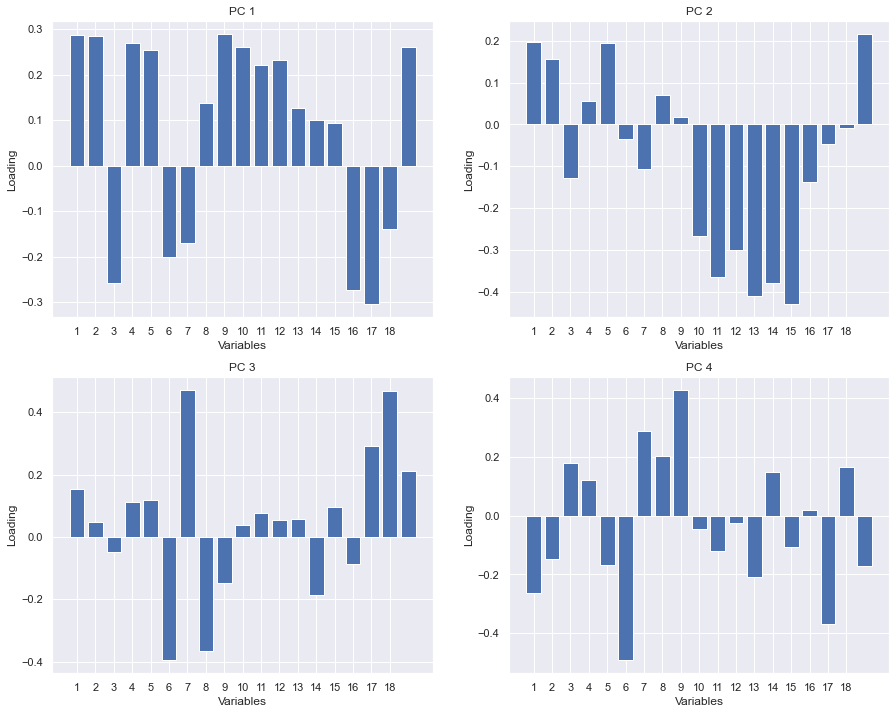

In [49]:
# interpreting loading values
# look at meaning
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
nums = np.linspace(1,18,18)
setting = {0:ax1,1:ax2,2:ax3,3:ax4}
for i,ax in setting.items():
    ax.bar(np.linspace(1,19,19),loadings2[i,:])
    ax.set_xlabel('Variables')
    ax.set_ylabel('Loading')
    ax.set_title("PC " + str(i+1))
    ax.set_xticks(nums)

The loading values are identical to the previous PCA. Will use same labels for PC 1-4

In [50]:
X_reduced2 = X_pca2[:,0:4]

In [51]:
model = LinearRegression().fit(X_reduced2, Y2)
b0, b1 = model.intercept_, (model.coef_).T
rSqr = model.score(X_reduced2, Y2)
adj_rSqr = 1-(1-rSqr)*(n-1)/(n-p-1)
rmse = mse(y_true=Y2, y_pred=model.predict(X_reduced2), squared=False)
pcr2_metrics = [adj_rSqr, rmse]
pca_dict = {"PC1: school competence":b1[0],
            "PC2: poor school climate":b1[1],
            "PC3: large school size":b1[2],
            "PC3: nice school community":b1[3]}
print("PCR on objective student achievement scores")
print("Adjusted R^2", adj_rSqr)
print("RMSE:", rmse)
pcr2_results = pd.DataFrame.from_dict(data=pca_dict, orient='index',columns=['Coefficients'])
pcr2_results

PCR on objective student achievement scores
Adjusted R^2 0.2454158576317923
RMSE: 0.8647813503737264


,Coefficients
PC1: school competence,0.183089
PC2: poor school climate,-0.116678
PC3: large school size,0.056025
PC3: nice school community,0.073012


### Comparing performance with basic multiple regresison

In [52]:
d1 = {"adj_R^2": [bm1_metrics[0], pcr1_metrics[0], bm2_metrics[0], pcr2_metrics[0]],
      "RMSE":[bm1_metrics[1], pcr1_metrics[1], bm2_metrics[1], pcr2_metrics[1]]}
pd.DataFrame(data=d1, index=['bm1', 'pcr1', 'bm2', 'pcr2'])

,adj_R^2,RMSE
bm1,0.704322,0.532727
pcr1,0.444672,0.741869
bm2,0.341176,0.795207
pcr2,0.245416,0.864781


### Observations
- Overall, the predictors are much more interpretable. In the base model for both outcomes, race (i.e., white/black/asian percent) had the highest coefficients. However, race as just a single factor is not helpful in understanding what leads to higher SHS acceptances and achievement test scores
- It seems that school competence is the best predictor of SHS acceptances and achievement test score
- The adjusted R squared is much lower in the PCR models than the base models.
    - Ideally the adjusted R squared value should account for the difference in the number of predictors. However, since the sample size is very large (449), the difference in the regular R squared and adjusted R squared value is much smaller.
    - Thus, R squared is much larger in the base models because there are more predictors

## Lasso Regression (LR)

In [63]:
## Train-test split, then standardize to avoid data leakage
# select predictors/outcomes and standardize them
# outcome1: acceptances
# outcome2: achievement test scores
# features: all else, except for column 20 and 21 (reading and math scores)

Y1_ml = np.array(reducedData['acceptances']).reshape(-1,1) # acceptances
Y2_ml = np.array(reducedData['student_achievement']).reshape(-1,1)# achievement test scores
X1_ml = pd.concat([reducedData.iloc[:,0],reducedData.iloc[:,2:20]],axis=1)
X2_ml = pd.concat([reducedData.iloc[:,0:2],reducedData.iloc[:,2:19]],axis=1)

# split data
xTrain_y1, xTest_y1, yTrain_y1, yTest_y1 = model_selection.train_test_split(X1_ml, Y1_ml, test_size=0.3, random_state=0)
xTrain_y2, xTest_y2, yTrain_y2, yTest_y2 = model_selection.train_test_split(X2_ml, Y2_ml, test_size=0.3, random_state=0)

# standardize data
xTrain_y1 = StandardScaler().fit_transform(xTrain_y1)
xTest_y1 = StandardScaler().fit_transform(xTest_y1)
yTrain_y1 = StandardScaler().fit_transform(yTrain_y1)
yTest_y1 = StandardScaler().fit_transform(yTest_y1)
xTrain_y2 = StandardScaler().fit_transform(xTrain_y2)
xTest_y2 = StandardScaler().fit_transform(xTest_y2)
yTrain_y2 = StandardScaler().fit_transform(yTrain_y2)
yTest_y2 = StandardScaler().fit_transform(yTest_y2)

### SHS Acceptances

100%|██████████| 1001/1001 [00:00<00:00, 2109.95it/s]


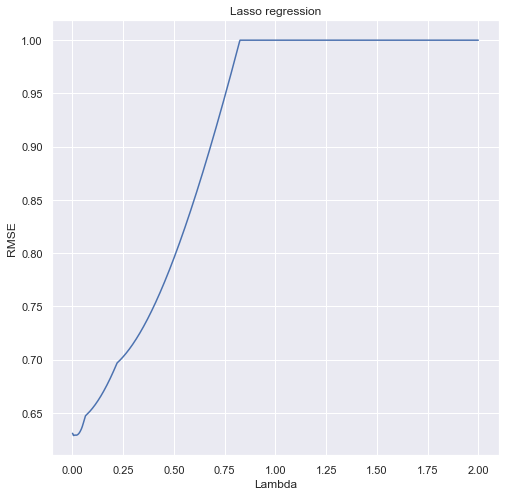

Optimal lambda: 0.0061994


,predictors,base_Y1,lasso_Y1
0,applications,0.867077,0.898577
1,per_pupil_spending,-0.008407,0.000000
2,avg_class_size,0.011645,-0.000000
3,asian_percent,3.852973,0.046697
4,black_percent,6.153784,-0.010537
5,hispanic_percent,5.997661,-0.000000
6,multiple_percent,0.607072,0.024887
7,white_percent,4.276178,0.000000
8,rigorous_instruction,-0.043776,0.000000
9,collaborative_teachers,0.039989,0.004170


In [64]:
# hyperparameter
lambdas = np.linspace(0.0002,2,1001) # 10001 evenly spaced samples of lambdas from 0-30
cont = np.empty([len(lambdas),2])*np.NaN # [lambda error]

for i in tqdm(range(len(lambdas))):
    lassoModel = Lasso(alpha=lambdas[i]).fit(xTrain_y1, yTrain_y1)
    cont[i,0] = lambdas[i]
    error = mse(yTest_y1,lassoModel.predict(xTest_y1),squared=False)
    cont[i,1] = error
plt.figure(figsize=(8,8))
plt.plot(cont[:,0],cont[:,1])
plt.xlabel('Lambda')
plt.ylabel('RMSE')
plt.title('Lasso regression')
plt.show()
print('Optimal lambda:',lambdas[np.argmax(cont[:,1]==np.min(cont[:,1]))])

# create metrics
optimal = lambdas[np.argmax(cont[:,1]==np.min(cont[:,1]))]
lasso1 = Lasso(alpha=optimal).fit(xTrain_y1, yTrain_y1)
l1_y_pred = lasso1.predict(xTest_y1)
rmse = mse(y_true=yTest_y1, y_pred=l1_y_pred, squared=False)
p = 18
n = X.shape[0]
rSqr = lasso1.score(xTest_y1, yTest_y1)
adj_rSqr = 1-(1-rSqr)*(n-1)/(n-p-1)
l1_metrics = [adj_rSqr, rmse]

# print results
l1_df = pd.DataFrame(data=lasso1.coef_, columns=['lasso_Y1'])
l1_results = pd.concat([bm1_results, l1_df],axis=1)
l1_results

### Observations:
- Numbers of applications ($\beta_1$=0.89) is the strongest predictor of SHS acceptances
- Poverty and school size ($\beta_1=-0.11$, $\beta_1=-0.24$) predict lower SHS acceptances
- In addition, student_achievement test scores were reduced to 0 as well
- Interestingly, racial factors, which had high coefficients in the base multiple regression model, dramatically reduced in the Lasso Regression
- Furthermore, school climate factors (i.e., predictors 9-14 (index 8-13) ), which had moderate contributions in the PCR model (PC 1 and 2), were dramatically reduced in the Lasso Regression
    - The PCR results may be different because the principal components had to incorporate all factors, which may induce noise
    - The LR results suggest that most of these factors are not relevant to predicting the outcome
        - In addition, PCA conducts dimension reduction without accounting for the outcome (bc its unsupervised), while lass regression takes into account the outcome

### Achievement Test Scores

100%|██████████| 1001/1001 [00:00<00:00, 1953.92it/s]


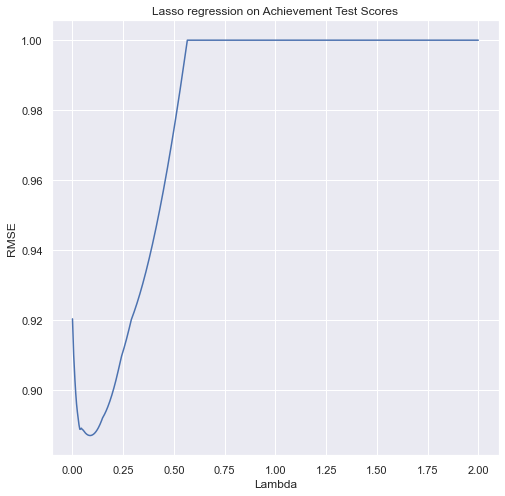

Optimal lambda: 0.0861914


,predictors,base_Y2,lasso_Y2
0,applications,0.089931,0.000000
1,acceptances,0.042256,0.000000
2,per_pupil_spending,-0.031753,-0.000000
3,avg_class_size,-0.037443,-0.000000
4,asian_percent,1.251001,0.040081
5,black_percent,1.768683,-0.102537
6,hispanic_percent,1.800015,-0.000000
7,multiple_percent,0.157107,0.000000
8,white_percent,1.459492,0.078780
9,rigorous_instruction,0.189624,0.055439


In [65]:
# hyperparameter
lambdas = np.linspace(0.0002,2,1001) # 10001 evenly spaced samples of lambdas from 0-30
cont = np.empty([len(lambdas),2])*np.NaN # [lambda error]

for i in tqdm(range(len(lambdas))):
    lassoModel = Lasso(alpha=lambdas[i]).fit(xTrain_y2, yTrain_y2)
    cont[i,0] = lambdas[i]
    error = mse(yTest_y2,lassoModel.predict(xTest_y2),squared=False)
    cont[i,1] = error

# plot graph
plt.figure(figsize=(8,8))
plt.plot(cont[:,0],cont[:,1])
plt.xlabel('Lambda')
plt.ylabel('RMSE')
plt.title('Lasso regression on Achievement Test Scores')
plt.show()
print('Optimal lambda:',lambdas[np.argmax(cont[:,1]==np.min(cont[:,1]))])

# compute metrics
optimal = lambdas[np.argmax(cont[:,1]==np.min(cont[:,1]))]
lasso2 = Lasso(alpha=optimal).fit(xTrain_y2, yTrain_y2)
l2_y_pred = lasso2.predict(xTest_y2)
rmse = mse(y_true=yTest_y2, y_pred=l2_y_pred, squared=False)
p = 18
n = X.shape[0]
rSqr = lasso2.score(xTest_y2, yTest_y2)
adj_rSqr = 1-(1-rSqr)*(n-1)/(n-p-1)
l2_metrics = [adj_rSqr, rmse]

## print results
l2_df = pd.DataFrame(data=lasso2.coef_, columns=['lasso_Y2'])
l2_results = pd.concat([bm2_results, l2_df],axis=1)
l2_results

### Observations:
- Similar to previous LR with SPS acceptances as the outcome, most factors are reduced to 0 (including acceptances)
- Surprisingly, both acceptances and applications are reduced to 0
- Supportive environment ($\beta_1=0.39$) is the strongest predictor of achievement test scores

### Comparison with other models

In [66]:
d1 = {"adj_R^2": [bm1_metrics[0], pcr1_metrics[0], l1_metrics[0], bm2_metrics[0], pcr2_metrics[0], l2_metrics[0] ],
      "RMSE":[bm1_metrics[1], pcr1_metrics[1], l1_metrics[1], bm2_metrics[1], pcr2_metrics[1], l2_metrics[1]]}
pd.DataFrame(data=d1, index=['bm1', 'pcr1', 'l1', 'bm2', 'pcr2', 'l2'])

,adj_R^2,RMSE
bm1,0.704322,0.532727
pcr1,0.444672,0.741869
l1,0.588118,0.628756
bm2,0.341176,0.795207
pcr2,0.245416,0.864781
l2,0.180133,0.887088


- Interestingly, the results for predicting SPS acceptances and achievement test scores are different
- the lasso regression for SPS acceptances performs better than the PCR model (lower RMSE and higher $R^2$).
    - However, performs worse than the base model. However, the higher $R^2$ value in the base model can be contributed to the sheer amount of predictors. The RMSE is higher in the lasso regression because it measures the test error, while the base model uses the training error, which often underestimates the test error
- In regards to predicting achievement test scores, the lasso regression performs worse than the PCR model. However, again the PCA is an unsupervised model, which does not take into account the outcome, so the results should not be taken as face value

## Ridge Regression
- An additional analysis in case the Lasso regression assumption does not hold true (i.e., there are only a few meaningful predictors)

### SHS Acceptances

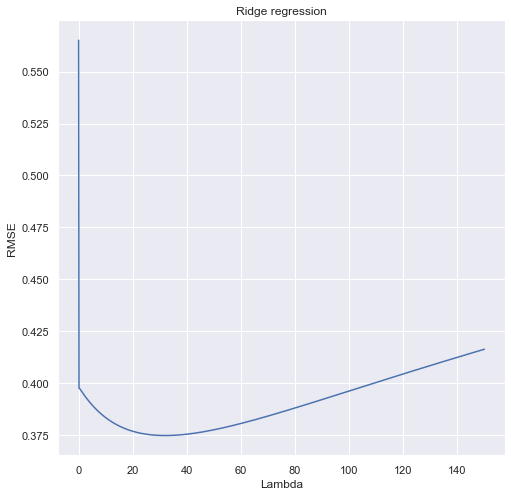

Optimal lambda: 31.95


,predictors,base_Y1,lasso_Y1,Ridge_Y1
0,applications,0.867077,0.898577,0.673272
1,per_pupil_spending,-0.008407,0.000000,0.016950
2,avg_class_size,0.011645,-0.000000,0.001887
3,asian_percent,3.852973,0.046697,0.088399
4,black_percent,6.153784,-0.010537,-0.028848
5,hispanic_percent,5.997661,-0.000000,-0.033009
6,multiple_percent,0.607072,0.024887,0.023513
7,white_percent,4.276178,0.000000,0.006165
8,rigorous_instruction,-0.043776,0.000000,0.001648
9,collaborative_teachers,0.039989,0.004170,0.019481


In [68]:
# Add hyperparameter tuning to the above example
lambdas = np.linspace(0,150,1001)
cont = np.empty([len(lambdas),2])*np.NaN # [lambda error]
#xTrain, xTest, yTrain, yTest = model_selection.train_test_split(X, Y1.reshape(-1,1), test_size=0.2, random_state=0)
for ii in range(len(lambdas)):
    ridgeModel = Ridge(alpha=lambdas[ii]).fit(xTrain_y1, yTrain_y1)
    cont[ii,0] = lambdas[ii]
    error = metrics.mean_squared_error(yTest_y1,ridgeModel.predict(xTest_y1))
    cont[ii,1] = error

# plot graph
plt.figure(figsize=(8,8))
plt.plot(cont[:,0],cont[:,1])
plt.xlabel('Lambda')
plt.ylabel('RMSE')
plt.title('Ridge regression')
plt.show()
print('Optimal lambda:',lambdas[np.argmax(cont[:,1]==np.min(cont[:,1]))])

# Computing metrics
optimal = lambdas[np.argmax(cont[:,1]==np.min(cont[:,1]))]
ridge1 = Ridge(alpha=39.3).fit(xTrain_y1, yTrain_y1)
r1_y_pred = ridge1.predict(xTest_y1)
rmse = mse(y_true=yTest_y1, y_pred=r1_y_pred, squared=False)
p = 18
n = X.shape[0]
rSqr = ridge1.score(xTest_y1,yTest_y1)
adj_rSqr = 1-(1-rSqr)*(n-1)/(n-p-1)
r1_metrics = [adj_rSqr, rmse]

# printing results
r1_df = pd.DataFrame(data=ridge1.coef_.T, columns=['Ridge_Y1'])
r1_results = pd.concat([l1_results, r1_df],axis=1)
r1_results

### Achievement Test Scorse

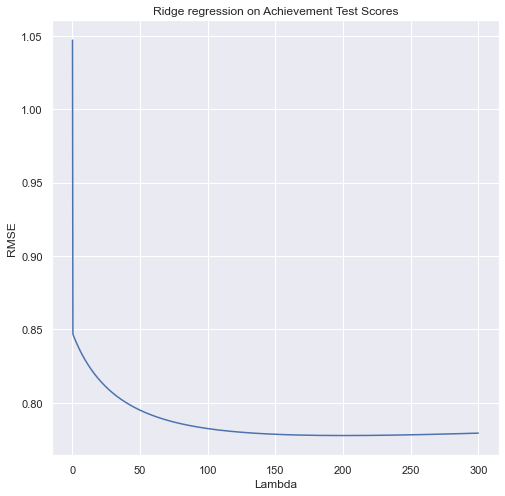

Optimal lambda: 200.7


,predictors,base_Y2,lasso_Y2,Ridge_Y2
0,applications,0.089931,0.000000,0.079640
1,acceptances,0.042256,0.000000,0.009553
2,per_pupil_spending,-0.031753,-0.000000,-0.016694
3,avg_class_size,-0.037443,-0.000000,-0.050370
4,asian_percent,1.251001,0.040081,0.113130
5,black_percent,1.768683,-0.102537,-0.154702
6,hispanic_percent,1.800015,-0.000000,-0.004037
7,multiple_percent,0.157107,0.000000,0.031777
8,white_percent,1.459492,0.078780,0.118152
9,rigorous_instruction,0.189624,0.055439,0.124669


In [69]:
# Add hyperparameter tuning to the above example
lambdas = np.linspace(0,300,1001)
cont = np.empty([len(lambdas),2])*np.NaN # [lambda error]
for ii in range(len(lambdas)):
    ridgeModel = Ridge(alpha=lambdas[ii]).fit(xTrain_y2, yTrain_y2)
    cont[ii,0] = lambdas[ii]
    error = metrics.mean_squared_error(yTest_y2,ridgeModel.predict(xTest_y2))
    cont[ii,1] = error

# plot graph
plt.figure(figsize=(8,8))
plt.plot(cont[:,0],cont[:,1])
plt.xlabel('Lambda')
plt.ylabel('RMSE')
plt.title('Ridge regression on Achievement Test Scores')
plt.show()
print('Optimal lambda:',lambdas[np.argmax(cont[:,1]==np.min(cont[:,1]))])

# compute metrics
optimal = lambdas[np.argmax(cont[:,1]==np.min(cont[:,1]))]
ridge2 = Ridge(alpha=39.3).fit(xTrain_y2, yTrain_y2)
r2_y_pred = ridge2.predict(xTest_y2)
rmse = mse(y_true=yTest_y2, y_pred=r2_y_pred, squared=False)
p = 18
n = X.shape[0]
rSqr = ridge2.score(xTest_y2, yTest_y2)
adj_rSqr = 1-(1-rSqr)*(n-1)/(n-p-1)
r2_metrics = [adj_rSqr, rmse]

# print results
r2_df = pd.DataFrame(data=ridge2.coef_.T, columns=['Ridge_Y2'])
r2_results = pd.concat([l2_results, r2_df],axis=1)
r2_results

In [70]:
d1 = {"adj_R^2": [bm1_metrics[0], pcr1_metrics[0], l1_metrics[0], r1_metrics[0], bm2_metrics[0], pcr2_metrics[0], l2_metrics[0], r2_metrics[0]],
      "RMSE":[bm1_metrics[1], pcr1_metrics[1], l1_metrics[1], r1_metrics[1], bm2_metrics[1], pcr2_metrics[1], l2_metrics[1], r2_metrics[1]]}
final_metrics = pd.DataFrame(data=d1, index=['bm1', 'pcr1', 'l1', 'r1', 'bm2', 'pcr2', 'l2', 'r2'])
final_metrics

,adj_R^2,RMSE
bm1,0.704322,0.532727
pcr1,0.444672,0.741869
l1,0.588118,0.628756
r1,0.609127,0.612510
bm2,0.341176,0.795207
pcr2,0.245416,0.864781
l2,0.180133,0.887088
r2,0.166157,0.894617


- Overall, the ridge regression model performed similarly to the lasso regression model in predicting SPS acceptances
- `Numbers of applications` ($\beta_1=0.67$) is the only major predictor of SPS acceptances, while Poverty and school size ($\beta_1=-0.10$, $\beta_1=-0.09$) predict lower SHS acceptances
- However, when predicting achievement test scores, in addition to `supportive environments` ($\beta_1=0.36$), the ridge regression provides that `rigorous instructions` ($\beta_1=0.12$),and `trust` ($\beta_1=0.11$).
- These results suggest that although individual school climiate variables are not relevant predictors of SPS acceptances, they are relevant in general student performances
- School competence does not translate to both student applications and acceptances. So the number of applications likely capture another latent variable such as peer pressure and being surrounded by like minded people

## Visualizations for Tableau Dasboard

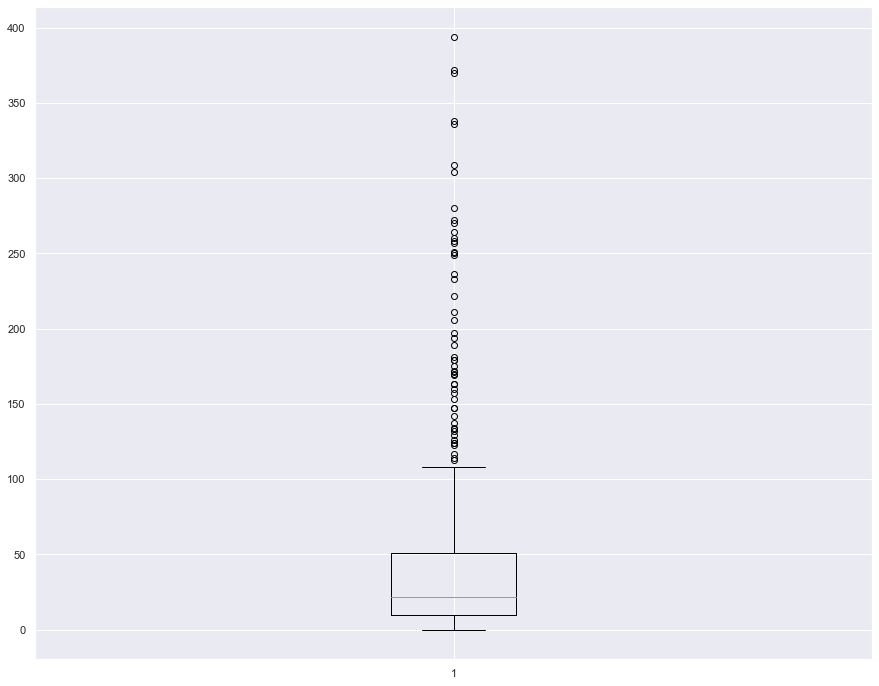

In [29]:
# general distribution of applications
plt.boxplot(reducedData['applications'])
plt.show()

In [30]:
reducedData['applications'].describe()

count    449.000000
mean      47.474388
std       67.064434
min        0.000000
25%       10.000000
50%       22.000000
75%       51.000000
max      394.000000
Name: applications, dtype: float64

In [31]:
# Format dataset for tableau use
# add new column for acceptance rates and percentile
perc_25 = reducedData['applications'].quantile(q=0.25)
perc_50 = reducedData['applications'].quantile(q=0.50)
perc_75 = reducedData['applications'].quantile(q=0.75)

data_format = reducedData.copy()
data_format['acceptance_rate'] = np.round(data_format['acceptances']/data_format['applications'],2) # create
# create a list of percentile conditions
conditions = [
    (data_format['applications'] <= perc_25),
    (data_format['applications'] > perc_25) & (data_format['applications'] <= perc_50),
    (data_format['applications'] > perc_50) & (data_format['applications'] <= perc_75),
    (data_format['applications'] > perc_75)
]
# create labels
percentile = ['0-25th', '25-50th', '50-75th', '75-100th']

# create a new column and use np.select to assign values to it using our lists as arguments
data_format['percentile'] = np.select(conditions, percentile)

data_format.to_csv('cleaned.csv') # save dataset as csv

In [32]:
results = data_format.groupby(by='percentile')[['applications','acceptances','acceptance_rate']].sum()
results

,applications,acceptances,acceptance_rate
percentile,,,
0-25th,570,9,0.95
25-50th,1733,70,4.00
50-75th,3706,364,10.38
75-100th,15307,3749,24.61


In [33]:
# Simple Statistics (listed as Key Stats)
# print % of schools with 0 applications
data_format[data_format['applications']==0].shape[0]/data_format.shape[0]

0.1091314031180401

In [34]:
# print % of all applications that the top 25% of schools account for
data_format[data_format['applications']>perc_75]['applications'].sum()/data_format['applications'].sum()

0.7180990805029086

In [35]:
# print % of all acceptances that the top 25% of schools account for
# subtract this by 1, to get the % of all acceptances that the other 75% of schools account for
data_format[data_format['acceptances']>2]['acceptances'].sum()/data_format['acceptances'].sum()

0.9329675572519084